In [14]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow

# Statistics imports
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp
import scipy.stats as ss

In [15]:
# Load the experiment from file
df = pd.read_feather('../../results/tabular-1.feather')

# Update the font to be same as in thesis
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': '\\usepackage{libertine}'
})

In [16]:
# Calculate ranks and means for each benchmark at specific budget
benchmark_names = df.index.get_level_values('benchmark').unique().tolist()
algos = df.index.get_level_values('algorithm').unique()
algos = ['ASHA', 'BOHB', 'DEHB', 'DyHPO', 'HYPERTUNE',
       'MOBSTER', 'RS', 'Hyperband']

frac = 1.0
avgs = []
ranks = []
means = []
for benchmark_name in benchmark_names:
    # Load correct subset of the dataframe
    print(f"Calculating {benchmark_name}")
    bench_df = df.loc[(benchmark_name, algos, slice(None), slice(None))]
    bench_df = bench_df.reset_index(level='trial')
    budget = bench_df['max_num_evaluations'].iloc[0]

    # Calculate cumulative metric and ranks
    filtered = bench_df[bench_df['trial'] == frac * budget]
    ranks_df = filtered.groupby('algorithm')['regret'].mean().rank()
    ranks_df.rename(f'{benchmark_name}', inplace=True)
    cum_mean = filtered.groupby('algorithm')['regret'].mean()
    cum_mean.rename(f'{benchmark_name}', inplace=True)
    ranks.append(ranks_df)
    means.append(cum_mean)
ranks = pd.concat(ranks, axis=1)
means = pd.concat(means, axis=1)

means

Calculating fcnet-naval
Calculating fcnet-parkinsons
Calculating fcnet-protein
Calculating fcnet-slice
Calculating lcbench-Fashion-MNIST
Calculating lcbench-airlines
Calculating lcbench-albert
Calculating lcbench-christine
Calculating lcbench-covertype
Calculating lcbench-dionis
Calculating lcbench-helena
Calculating lcbench-higgs
Calculating nas201-ImageNet16-120
Calculating nas201-cifar10
Calculating nas201-cifar100


,fcnet-naval,fcnet-parkinsons,fcnet-protein,fcnet-slice,lcbench-Fashion-MNIST,lcbench-airlines,lcbench-albert,lcbench-christine,lcbench-covertype,lcbench-dionis,lcbench-helena,lcbench-higgs,nas201-ImageNet16-120,nas201-cifar10,nas201-cifar100
algorithm,,,,,,,,,,,,,,,
ASHA,0.000096,0.008388,0.082390,0.009230,0.027707,0.193133,0.080581,0.078181,0.322456,0.075806,0.097574,0.082949,0.031339,0.007193,0.023584
BOHB,0.000048,0.007012,0.051613,0.008095,0.039448,0.200503,0.100202,0.091212,0.334527,0.118425,0.104286,0.036892,0.030156,0.006695,0.021352
DEHB,0.000137,0.009805,0.070890,0.008568,0.083048,0.260081,0.130128,0.088787,0.320761,0.109078,0.104915,0.105934,0.036953,0.012347,0.036922
DyHPO,0.000053,0.004968,0.036503,0.012505,0.016833,0.059337,0.071049,0.106666,0.087936,0.071489,0.081739,0.069234,0.019383,0.003882,0.019318
HYPERTUNE,0.000041,0.006408,0.027588,0.006478,0.052213,0.140200,0.088824,0.099999,0.215108,0.103688,0.095687,0.087796,0.014922,0.003929,0.007461
Hyperband,0.000088,0.008816,0.072128,0.008488,0.043017,0.248388,0.118311,0.073636,0.332512,0.114150,0.104667,0.068580,0.036978,0.010000,0.026972
MOBSTER,0.000030,0.005096,0.026914,0.006632,0.019332,0.135280,0.120770,0.093939,0.203580,0.140500,0.148468,0.092729,0.014498,0.004098,0.007554
RS,0.001073,0.024902,0.225535,0.033131,0.160766,0.538568,0.278950,0.072424,0.535771,0.260084,0.254738,0.225082,0.060380,0.015196,0.049165


In [17]:
# Benchmarks summary table
save = False

# Compute average runtime for each benchmark with random search
df_random = df.xs('RS', level='algorithm')
df_random = df_random.groupby(['benchmark', 'repeat']).last() #['elapsed_time'].mean()
times = df_random.groupby('benchmark')['elapsed_time'].mean()
times = (times / 60).round(0).astype(int).rename('Avg runtime (min)')
times = times.to_frame()
times['Budget'] = 0
times['Epochs'] = 0

benchmark_names = df.index.get_level_values('benchmark').unique().tolist()
for benchmark_name in benchmark_names:
    print(f"Calculating {benchmark_name}")
    budget = df.loc[(benchmark_name, 'RS', 1, 1)]['max_num_evaluations']
    times.loc[benchmark_name, 'Epochs'] = budget/20
    times.loc[benchmark_name, 'Budget'] = budget

# Rename colummns
times.columns = [r'Avg.\ runtime (min)', 'Budget', 'Epochs']
times = times[['Epochs', 'Budget', r'Avg.\ runtime (min)']]
times.index.name = 'Benchmark'
print(times)

# Convert to latex and save
caption = 'Summary of the tasks from tabular benchmarks used in the experiment. A total of 15 tasks were drawn from 3 tabular benchmarks. The columns indicate the maximum number of epochs for training a single configuration, the total budget for the experiment in terms of epochs, and the average runtime of each task in minutes, which includes the training time. Only random search runs contribute to the average runtime. Also, the training time is simply added to the sum, as retrieving information from the tables is nearly instant.'
latex_table = times.to_latex()
latex_table_custom = times.to_latex(index=True,
        caption=caption,
        label='tab:tab_summary',
        column_format='lccc',
        #position='H',
        escape=False)
print(latex_table)

if save:
    with open(f'../../thesis/tables/tabular_summary.tex', 'w') as file:
        file.write(latex_table_custom)


Calculating fcnet-naval
Calculating fcnet-parkinsons
Calculating fcnet-protein
Calculating fcnet-slice
Calculating lcbench-Fashion-MNIST
Calculating lcbench-airlines
Calculating lcbench-albert
Calculating lcbench-christine
Calculating lcbench-covertype
Calculating lcbench-dionis
Calculating lcbench-helena
Calculating lcbench-higgs
Calculating nas201-ImageNet16-120
Calculating nas201-cifar10
Calculating nas201-cifar100
                       Epochs  Budget  Avg.\ runtime (min)
Benchmark                                                 
fcnet-naval               100    2000                   26
fcnet-parkinsons          100    2000                   14
fcnet-protein             100    2000                   92
fcnet-slice               100    2000                  173
lcbench-Fashion-MNIST      50    1000                  303
lcbench-airlines           50    1000                  487
lcbench-albert             50    1000                  593
lcbench-christine          50    1000          

### Perform the Friedman + Wilcoxon test on regret

In [18]:
np_means = means.to_numpy()
friedman_stat, p_value = ss.friedmanchisquare(*np_means)
print(f"Friedman test statistic: {friedman_stat}, p-value: {p_value}")

Friedman test statistic: 47.888888888888914, p-value: 3.7431917548540393e-08


In [19]:
melted = means.melt(ignore_index=False, var_name='benchmark')
melted = melted.reset_index()
melted

,algorithm,benchmark,value
0,ASHA,fcnet-naval,0.000096
1,BOHB,fcnet-naval,0.000048
2,DEHB,fcnet-naval,0.000137
3,DyHPO,fcnet-naval,0.000053
4,HYPERTUNE,fcnet-naval,0.000041
...,...,...,...
115,DyHPO,nas201-cifar100,0.019318
116,HYPERTUNE,nas201-cifar100,0.007461
117,Hyperband,nas201-cifar100,0.026972
118,MOBSTER,nas201-cifar100,0.007554


               ASHA      BOHB      DEHB     DyHPO  HYPERTUNE  Hyperband  \
ASHA       1.000000  1.000000  0.150513  0.127563   1.000000   0.962952   
BOHB       1.000000  1.000000  0.409180  0.670776   0.670776   0.618896   
DEHB       0.150513  0.409180  1.000000  0.040283   0.024353   0.670776   
DyHPO      0.127563  0.670776  0.040283  1.000000   0.962952   0.174316   
HYPERTUNE  1.000000  0.670776  0.024353  0.962952   1.000000   0.670776   
Hyperband  0.962952  0.618896  0.670776  0.174316   0.670776   1.000000   
MOBSTER    1.000000  1.000000  0.670776  1.000000   1.000000   1.000000   
RS         0.005127  0.011108  0.014648  0.018799   0.014648   0.005127   

            MOBSTER        RS  
ASHA       1.000000  0.005127  
BOHB       1.000000  0.011108  
DEHB       0.670776  0.014648  
DyHPO      1.000000  0.018799  
HYPERTUNE  1.000000  0.014648  
Hyperband  1.000000  0.005127  
MOBSTER    1.000000  0.011108  
RS         0.011108  1.000000  


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1c087779540>)

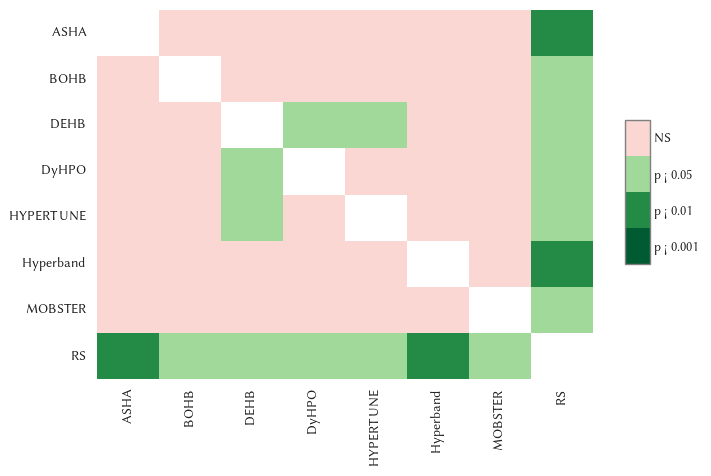

In [20]:
wilcoxon_results = sp.posthoc_wilcoxon(melted, val_col='value', group_col='algorithm', p_adjust='holm')
# Groups - datasets
# Val_col - algorithm - calculate differences between algorithms
print(wilcoxon_results)
sp.sign_plot(wilcoxon_results)

c:\Users\rostu\Documents\MastersThesis\.st_venv\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


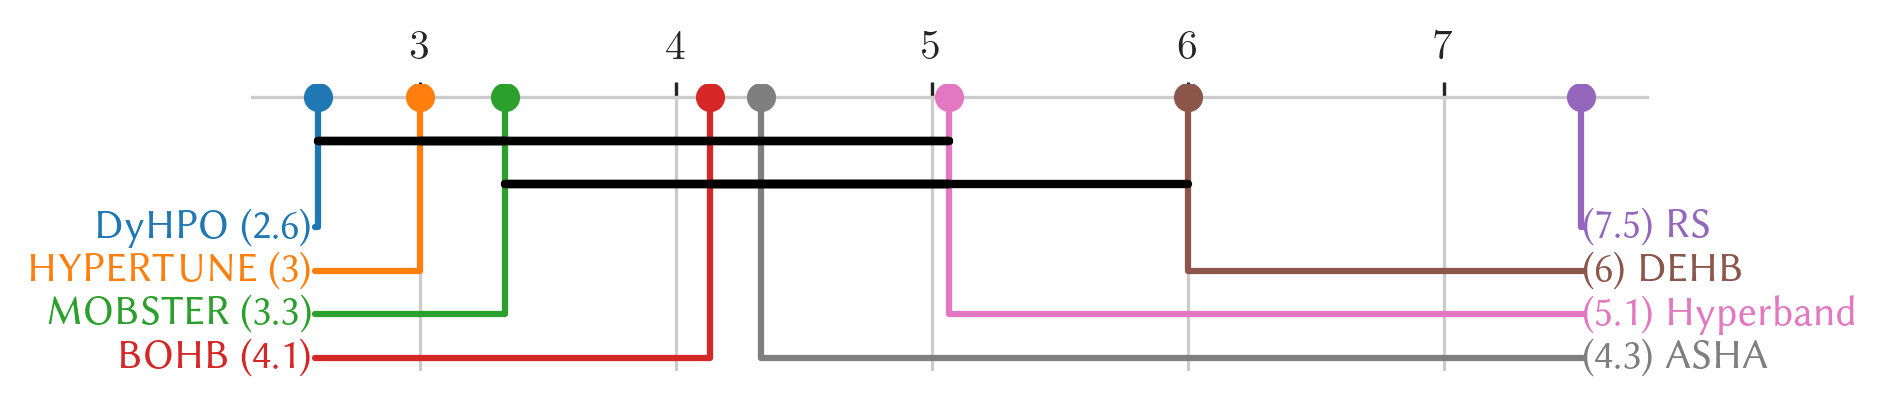

In [21]:
plt.figure(figsize=(6, 1.24), dpi=300)
#plt.title('Critical difference diagram of average score ranks')
sp.critical_difference_diagram(ranks.mean(axis=1), wilcoxon_results)
plt.rcParams['savefig.format'] = 'pdf'
plt.savefig('../../thesis/img/tabular_exp/cd_diagram', bbox_inches='tight')

### Algorithm runtime

In [22]:
# Calculate overhead
time_df = df[['elapsed_time', 'metric_elapsed_time', 'st_decision', 'trial_id']]
exp_df = time_df.loc[('fcnet-naval', 'DyHPO', 1, slice(None))]
exp_df.reset_index(inplace=True)
exp_df['new_time'] = exp_df['metric_elapsed_time']
for i in range(len(exp_df) - 1):
    if exp_df.at[i, 'st_decision'] == 'CONTINUE' and exp_df.at[i, 'trial_id'] == exp_df.at[i + 1, 'trial_id']:
        exp_df.at[i + 1, 'new_time'] -= exp_df.at[i, 'metric_elapsed_time']

exp_df['cum_metric'] = exp_df['new_time'].cumsum()
exp_df['overhead'] = exp_df['elapsed_time'] - exp_df['cum_metric']
exp_df.drop(columns=['metric_elapsed_time', 'new_time'], inplace=True)

print(exp_df)

      trial  elapsed_time st_decision  trial_id   cum_metric     overhead
0         1      0.785809       PAUSE         0     0.682469     0.103340
1         2      5.897256       PAUSE         1     1.370775     4.526481
2         3     11.021182       PAUSE         2     2.077343     8.943838
3         4     16.031821       PAUSE         3     2.688640    13.343181
4         5     20.891683       PAUSE         4     3.053594    17.838088
...     ...           ...         ...       ...          ...          ...
1997   1998   8165.033156       PAUSE       153  3366.488033  4798.545123
1998   1999   8169.945940    CONTINUE        69  3368.274990  4801.670950
1999   2000   8171.732897       PAUSE        69  3370.061947  4801.670950
2000   2001   8175.632474    CONTINUE       153  3372.430309  4803.202165
2001   2002   8178.000837       PAUSE       153  3374.798672  4803.202165

[2002 rows x 6 columns]


C:\Users\rostu\AppData\Local\Temp\ipykernel_34224\3505446616.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df['new_time'] = exp_df['metric_elapsed_time']
C:\Users\rostu\AppData\Local\Temp\ipykernel_34224\3505446616.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df['cum_metric'] = exp_df['new_time'].cumsum()
C:\Users\rostu\AppData\Local\Temp\ipykernel_34224\3505446616.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [23]:
def compute_overhead(exp_df):
    exp_df.reset_index(inplace=True)
    exp_df['new_time'] = exp_df['metric_elapsed_time']
    for i in range(len(exp_df) - 1):
        if exp_df.at[i, 'st_decision'] == 'CONTINUE' and exp_df.at[i, 'trial_id'] == exp_df.at[i + 1, 'trial_id']:
            exp_df.at[i + 1, 'new_time'] -= exp_df.at[i, 'metric_elapsed_time']

    exp_df['cum_metric'] = exp_df['new_time'].cumsum()
    exp_df['overhead'] = exp_df['elapsed_time'] - exp_df['cum_metric']
    exp_df.drop(columns=['metric_elapsed_time', 'new_time'], inplace=True)
    exp_df['pause'] = np.where(exp_df['st_decision'] == 'PAUSE', 2.4, 0)
    exp_df['cum_pause'] = exp_df['pause'].cumsum()
    exp_df['overhead_compensated'] = exp_df['overhead'] - exp_df['cum_pause']
    return exp_df

fc_net_df = time_df.loc[('fcnet-naval', slice(None), slice(None), slice(None))]
df_new = fc_net_df.groupby(['algorithm', 'repeat']).apply(compute_overhead)

df_new


algorithm  repeat  trial  elapsed_time st_decision  \
algorithm repeat                                                           
ASHA      0      0         ASHA       0      1      0.784166       PAUSE   
                 1         ASHA       0      2      5.952882       PAUSE   
                 2         ASHA       0      3     11.056215    CONTINUE   
                 3         ASHA       0      4     11.802712       PAUSE   
                 4         ASHA       0      5     16.860750       PAUSE   
...                         ...     ...    ...           ...         ...   
RS        29     2008        RS      29   2009   1578.952748    CONTINUE   
                 2009        RS      29   2010   1579.303000    CONTINUE   
                 2010        RS      29   2011   1579.653252    CONTINUE   
                 2011        RS      29   2012   1580.003503    CONTINUE   
                 2012        RS      29   2013   1580.353756    CONTINUE   

                       trial_id   cum_metric   overhead  pause  cum_pause  \
algorithm repeat                                                            
ASHA      0      0            0     0.682469   0.101697    2.4        2.4   
                 1            1     1.428965   4.523917    2.4        4.8   
                 2            1     2.175461   8.880754    0.0        4.8   
                 3            1     2.921957   8.880754    2.4        7.2   
                 4            2     4.368375  12.492375    2.4        9.6   
...                         ...          ...        ...    ...        ...   
RS        29     2008        20  1526.365651  52.587096    0.0        0.0   
                 2009        20  1526.715903  52.587096    0.0        0.0   
                 2010        20  1527.066155  52.587096    0.0        0.0   
                 2011        20  1527.416407  52.587096    0.0        0.0   
                 2012        20  1527.766659  52.587097    0.0        0.0   

                       overhead_compensated  
algorithm repeat                             
ASHA      0      0                -2.298303  
                 1                -0.276083  
                 2                 4.080754  
                 3                 1.680754  
                 4                 2.892375  
...                                     ...  
RS        29     2008             52.587096  
                 2009             52.587096  
                 2010             52.587096  
                 2011             52.587096  
                 2012             52.587097  

[481043 rows x 11 columns]

C:\Users\rostu\AppData\Local\Temp\ipykernel_34224\2760216578.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_new_filtered, x='trial', y='overhead', hue='algorithm', ci=None)


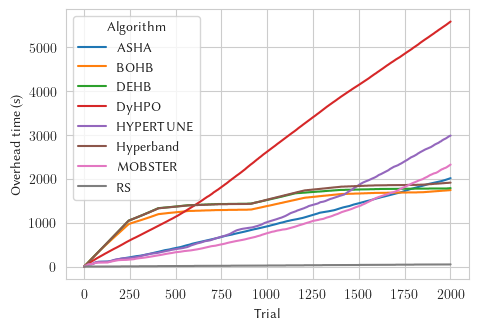

In [24]:
benchmark = 'fcnet-naval'

# Plot overhead time vs trial
df_new.index.set_names('trial', level=2, inplace=True)


df_new_filtered = df_new[df_new.index.get_level_values('trial') <= 2000]
# Plot the cumulative overhead for all algorithms
sns.set_style("whitegrid")
plt.figure(figsize=(5.2, 3.5))
sns.lineplot(data=df_new_filtered, x='trial', y='overhead', hue='algorithm', ci=None)
plt.xlabel('Trial')
plt.ylabel('Overhead time (s)')
plt.legend(title='Algorithm')
plt.rcParams['savefig.format'] = 'pdf'
plt.savefig('../../thesis/img/tabular_exp/overhead', bbox_inches='tight')

C:\Users\rostu\AppData\Local\Temp\ipykernel_34224\3737173782.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_new_filtered, x='trial', y='overhead_compensated', hue='algorithm', ci=None)


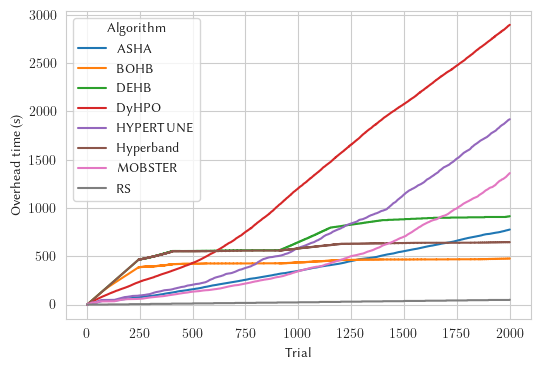

In [25]:
plt.figure(figsize=(6, 4))
sns.lineplot(data=df_new_filtered, x='trial', y='overhead_compensated', hue='algorithm', ci=None)
plt.xlabel('Trial')
plt.ylabel('Overhead time (s)')
plt.legend(title='Algorithm')

### Speedup factor compared to random search

In [26]:
rs_means = means.loc['RS']

# Average the results for each algorithm across repetitions
avg_regret = df.groupby(['benchmark', 'algorithm', 'trial'])['regret'].mean().to_frame()

In [27]:

# Return the trial where other algorithm surpass RS for each benchmark
def get_surpass_trial(group):
    benchmark_name = group.index.get_level_values('benchmark').unique()[0]
    rs_mean = rs_means[benchmark_name]
    group = group.reset_index('trial')
    surpass_trial = group[group['regret'] < rs_mean]['trial'].min()
    return pd.Series({'surpass_trial': surpass_trial})

surpass_trials = avg_regret.groupby(['benchmark', 'algorithm']).apply(get_surpass_trial)

In [28]:
# Calculate the speedup factor for each algorithm on each benchmark
budgets = {'n' : 4000, 'l' : 1000, 'f' : 2000}
def calculate_speedup(group):
    benchmark_name = group.index.get_level_values('benchmark').unique()[0]
    algorithm = group.index.get_level_values('algorithm').unique()[0]
    rs_trial = budgets[benchmark_name[0]]
    speedup =  rs_trial / surpass_trials.loc[(benchmark_name, algorithm)]['surpass_trial']
    return pd.Series({'speedup': speedup})

speedup = avg_regret.groupby(['benchmark', 'algorithm']).apply(calculate_speedup)
speedup.fillna(1, inplace=True)
speedup_old = speedup.copy()
speedup_old.reset_index(inplace=True)
speedup_old

,benchmark,algorithm,speedup
0,fcnet-naval,ASHA,7.092199
1,fcnet-naval,BOHB,2.919708
2,fcnet-naval,DEHB,2.717391
3,fcnet-naval,DyHPO,5.167959
4,fcnet-naval,HYPERTUNE,5.681818
...,...,...,...
115,nas201-cifar100,DyHPO,4.694836
116,nas201-cifar100,HYPERTUNE,4.866180
117,nas201-cifar100,Hyperband,4.040404
118,nas201-cifar100,MOBSTER,5.555556


In [29]:
# Calculate average speedup across benchmarks
speedup = speedup.groupby('algorithm').agg(['mean', 'std'])

In [30]:
speedup = speedup.droplevel(0, axis=1)
speedup.reset_index(inplace=True)
speedup

,algorithm,mean,std
0,ASHA,5.055717,1.614656
1,BOHB,5.010350,2.611367
2,DEHB,4.458623,2.113563
3,DyHPO,6.923020,3.431298
4,HYPERTUNE,5.690316,2.308710
5,Hyperband,4.523772,2.029389
6,MOBSTER,5.802772,2.333854
7,RS,0.998938,0.001884


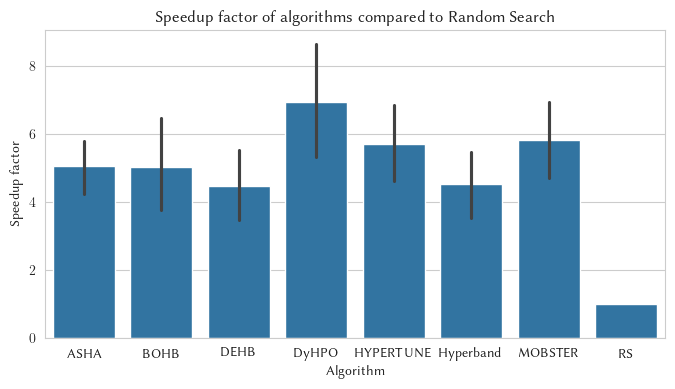

In [31]:
# Plot the speedup factor with stds
plt.figure(figsize=(8, 4), dpi=100)
sns.barplot(data=speedup_old, x='algorithm', y='speedup', errorbar=('ci', 95))
plt.ylabel('Speedup factor')
plt.xlabel('Algorithm')
plt.title('Speedup factor of algorithms compared to Random Search')
plt.show()

In [32]:
# Make a table of the speedup factor containing the mean and 95% confidence interval
def format_ci(stats_tuple):
    ci_lower, ci_upper = stats_tuple
    return f"[{ci_lower:.2f}, {ci_upper:.2f}]"

stats = speedup_old.groupby('algorithm')['speedup'].agg(['mean', 'sem', 'std'])
caption = 'This table shows the average speedup factor of the algorithms relative to Random Search across all benchmarks and repeated runs. Speedup factor indicates how much faster an algorithm finds a solution with the same objective function value as Random Search on full budget. A \SI{95}{\percent} confidence interval is provided for each speedup factor.'

stats['ci95 hi'] = stats['mean'] + 1.96* stats['sem']
stats['ci95 lo'] = stats['mean'] - 1.96* stats['sem']
stats['ci'] = stats.apply(lambda x: format_ci((x['ci95 lo'], x['ci95 hi'])), axis=1)
print(stats)

stats.drop(columns=['sem','std', 'ci95 lo', 'ci95 hi'], inplace=True)
stats.drop(axis=0, labels=['RS'], inplace=True)
stats.rename(columns={'ci': r'\SI{95}{\percent} CI', 'mean': 'Avg. speedup'}, inplace=True)
latex_table = stats.to_latex(float_format="%.2f")
latex_table_custom = stats.to_latex(index=True,
        caption=caption,
        label='tab:speedup',
        column_format='lcc',
        float_format="%.2f",
        escape=False)
print(latex_table)

with open('../../thesis/tables/tab_results.tex', 'w') as file:
    file.write(latex_table_custom)

               mean       sem       std   ci95 hi   ci95 lo            ci
algorithm                                                                
ASHA       5.055717  0.416902  1.614656  5.872846  4.238588  [4.24, 5.87]
BOHB       5.010350  0.674252  2.611367  6.331884  3.688816  [3.69, 6.33]
DEHB       4.458623  0.545720  2.113563  5.528234  3.389013  [3.39, 5.53]
DyHPO      6.923020  0.885957  3.431298  8.659496  5.186544  [5.19, 8.66]
HYPERTUNE  5.690316  0.596106  2.308710  6.858685  4.521947  [4.52, 6.86]
Hyperband  4.523772  0.523986  2.029389  5.550784  3.496759  [3.50, 5.55]
MOBSTER    5.802772  0.602598  2.333854  6.983864  4.621679  [4.62, 6.98]
RS         0.998938  0.000487  0.001884  0.999891  0.997984  [1.00, 1.00]
\begin{tabular}{lrl}
\toprule
 & Avg. speedup & \SI{95}{\percent} CI \\
algorithm &  &  \\
\midrule
ASHA & 5.06 & [4.24, 5.87] \\
BOHB & 5.01 & [3.69, 6.33] \\
DEHB & 4.46 & [3.39, 5.53] \\
DyHPO & 6.92 & [5.19, 8.66] \\
HYPERTUNE & 5.69 & [4.52, 6.86] \\
Hype

### Analysis or variance and normality of the results

benchmark: lcbench-Fashion-MNIST, algorithms: MOBSTER


<Axes: xlabel='cumulative', ylabel='Count'>

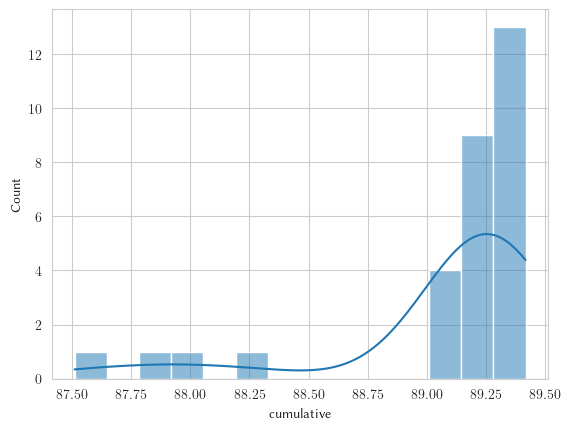

In [33]:
algorithms = df.index.get_level_values('algorithm').unique()
benchmarks = df.index.get_level_values('benchmark').unique()
bench_index = 4
algo_index= 6
print(f"benchmark: {benchmarks[bench_index]}, algorithms: {algorithms[algo_index]}")

bench_df = df.loc[(benchmarks[bench_index], algorithms[algo_index], slice(None), 1000)]
bench_df
# Plot PDF of the cumulative metric
sns.histplot(bench_df['cumulative'], kde=True)

In [34]:
# Compute the table of variance of the regret
subset = df.groupby(['benchmark', 'algorithm', 'repeat']).last()
variances = subset.groupby(['benchmark', 'algorithm'])['regret'].var().to_frame()
variances.rename(columns={'regret' : 'variance'}, inplace=True)
variances.reset_index(inplace=True)
variances = variances.pivot(columns='benchmark', values='variance', index='algorithm')
variances

stds = subset.groupby(['benchmark', 'algorithm'])['regret'].std().to_frame()
stds.rename(columns={'regret' : 'std'}, inplace=True)
stds.reset_index(inplace=True)
stds = stds.pivot(columns='benchmark', values='std', index='algorithm')
stds

benchmark,fcnet-naval,fcnet-parkinsons,fcnet-protein,fcnet-slice,lcbench-Fashion-MNIST,lcbench-airlines,lcbench-albert,lcbench-christine,lcbench-covertype,lcbench-dionis,lcbench-helena,lcbench-higgs,nas201-ImageNet16-120,nas201-cifar10,nas201-cifar100
algorithm,,,,,,,,,,,,,,,
ASHA,0.000065,0.004051,0.035433,0.004592,0.027981,0.128596,0.077581,0.017802,0.190467,0.051008,0.069301,0.073461,0.014224,0.003681,0.009646
BOHB,0.000086,0.003203,0.029636,0.004046,0.047881,0.176088,0.090896,0.019466,0.185963,0.110506,0.078325,0.045012,0.014271,0.003118,0.013052
DEHB,0.000131,0.004300,0.035357,0.004817,0.078676,0.194142,0.089426,0.030357,0.194902,0.076856,0.058349,0.076399,0.020247,0.006299,0.014403
DyHPO,0.000081,0.002832,0.020371,0.007107,0.032115,0.031534,0.099255,0.040931,0.132795,0.055922,0.037081,0.061058,0.015602,0.002253,0.018805
HYPERTUNE,0.000030,0.003894,0.019317,0.002908,0.062168,0.120161,0.075095,0.034843,0.188224,0.097348,0.059930,0.091843,0.009634,0.002467,0.007012
Hyperband,0.000047,0.003823,0.038311,0.002815,0.047641,0.166489,0.079592,0.020724,0.199650,0.086597,0.075094,0.059350,0.017817,0.003664,0.012668
MOBSTER,0.000020,0.003028,0.016837,0.003205,0.026282,0.140932,0.128615,0.034706,0.171323,0.095563,0.117497,0.092208,0.006051,0.002039,0.005851
RS,0.001475,0.015959,0.098822,0.026727,0.088365,0.248868,0.141950,0.049129,0.121640,0.145719,0.125507,0.114278,0.026287,0.006718,0.013713


In [35]:

# select the fcnet-naval benchmark
benchmark = 'fcnet-protein'
subset = df.loc[(benchmark, slice(None), slice(None), slice(None))]
# select only last row of each repeat
subset = subset.groupby(['algorithm', 'repeat']).last()
regret = subset['regret']
pd.set_option('display.max_rows', None)
print(regret)
pd.reset_option('display.max_rows')

algorithm  repeat
ASHA       0         0.076577
           1         0.112327
           2         0.025051
           3         0.090951
           4         0.057295
           5         0.086640
           6         0.046231
           7         0.080284
           8         0.020764
           9         0.083034
           10        0.156473
           11        0.085894
           12        0.103172
           13        0.053124
           14        0.103267
           15        0.106147
           16        0.053969
           17        0.109927
           18        0.051563
           19        0.118288
           20        0.121568
           21        0.092804
           22        0.148830
           23        0.060734
           24        0.118586
           25        0.022787
           26        0.028253
           27        0.102219
           28        0.079012
           29        0.075938
BOHB       0         0.033762
           1         0.012548
           2         0

algorithm
ASHA         0.241915
BOHB         0.299800
DEHB         0.424956
DyHPO        0.260403
HYPERTUNE    0.282539
Hyperband    0.309463
MOBSTER      0.316304
RS           0.926865
dtype: float64


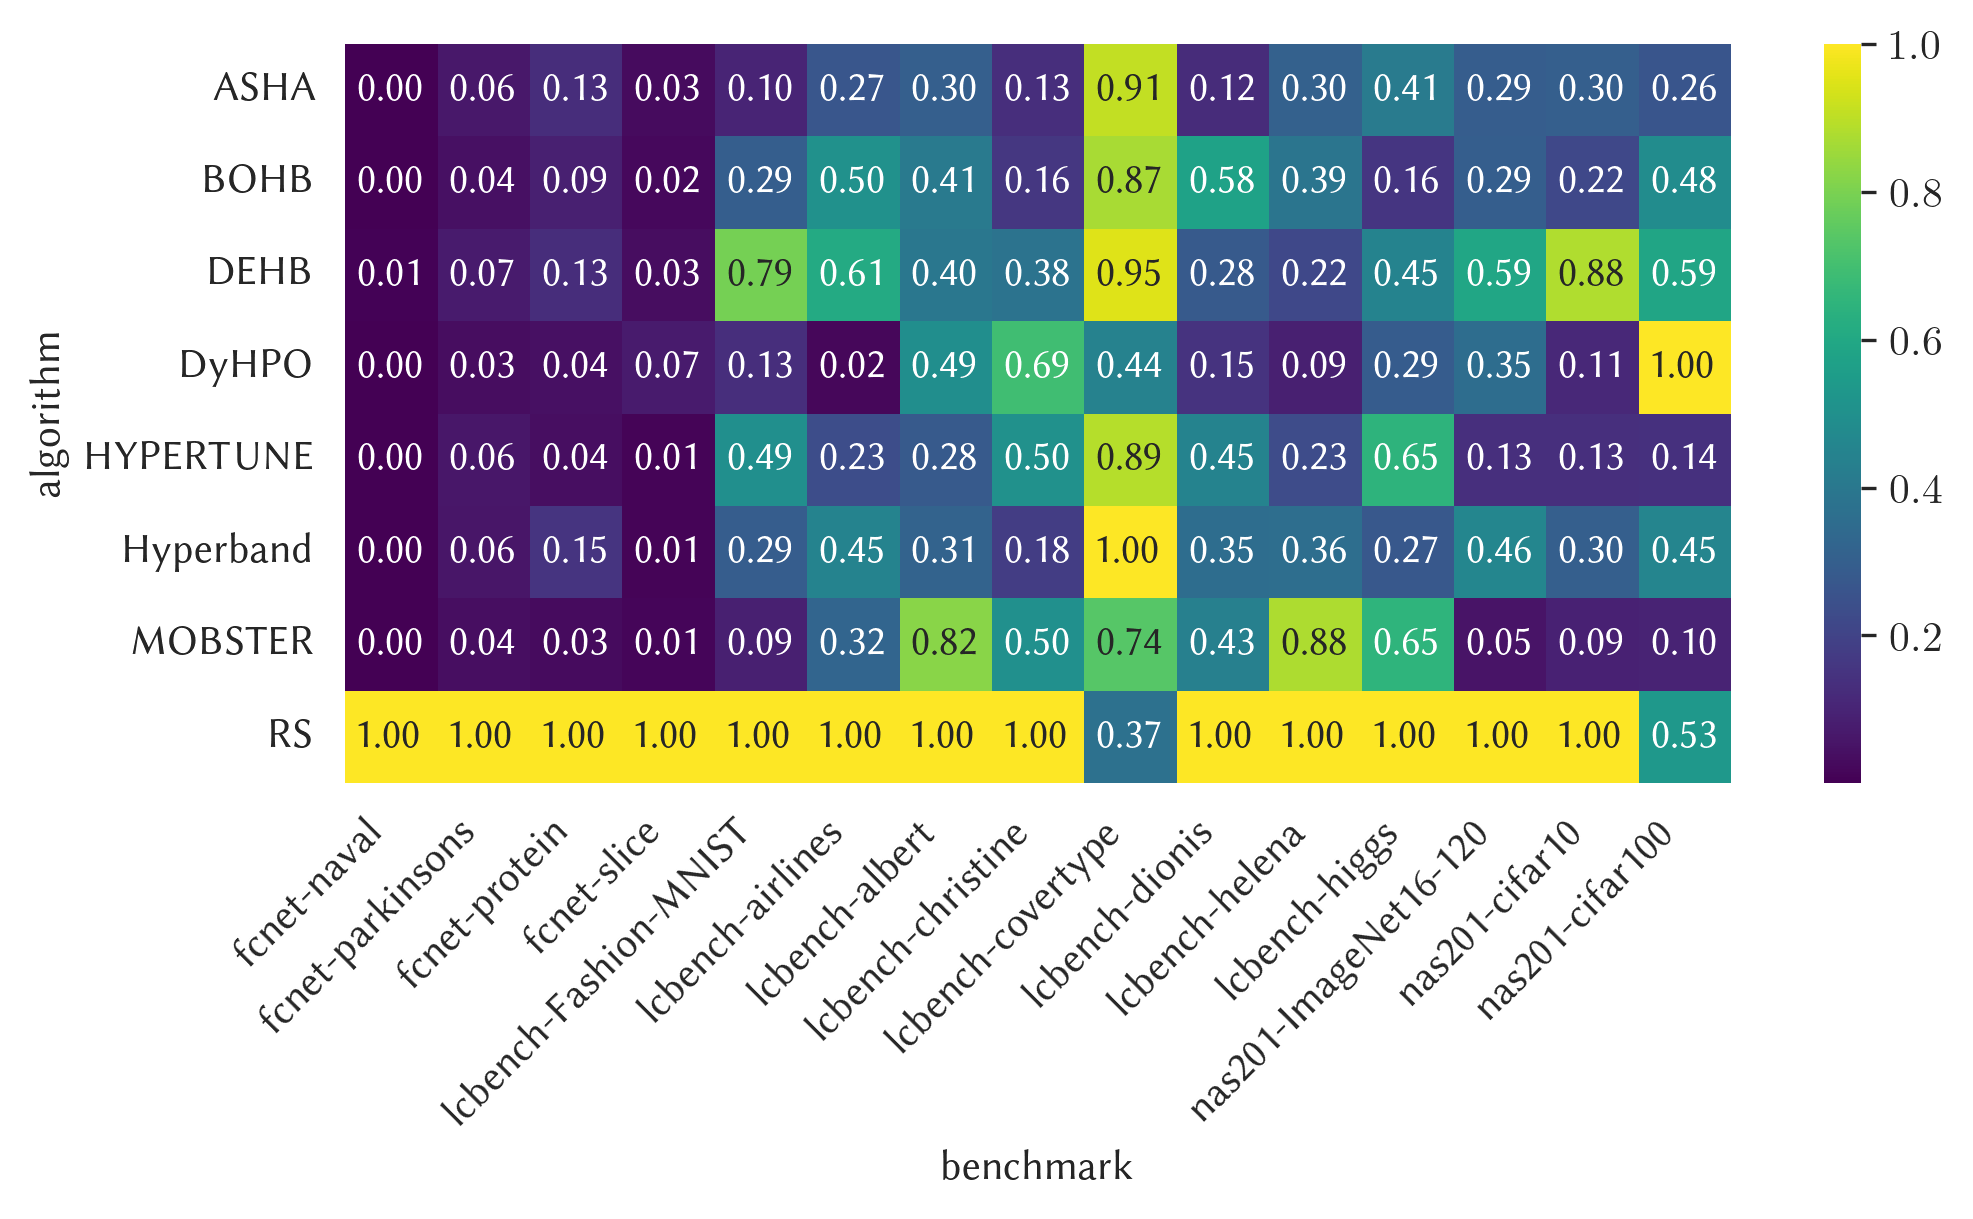

In [36]:
save = False
# Normalize variances for each column (benchmark)
variances = variances.div(variances.max(axis=0), axis=1)

print(variances.mean(axis=1))

# Plot the variances on a heatmap
plt.figure(figsize=(8, 3.2), dpi=300)
sns.heatmap(variances, annot=True, fmt=".2f", cmap='viridis', square=True)
plt.xticks(rotation=45, ha='right')
if save:
    plt.rcParams['savefig.format'] = 'pdf'
    plt.savefig('../../thesis/img/tabular_exp/variance_heatmap', bbox_inches='tight')

algorithm
ASHA         0.444793
BOHB         0.493689
DEHB         0.595021
DyHPO        0.435631
HYPERTUNE    0.466114
Hyperband    0.504266
MOBSTER      0.471444
RS           0.955899
dtype: float64


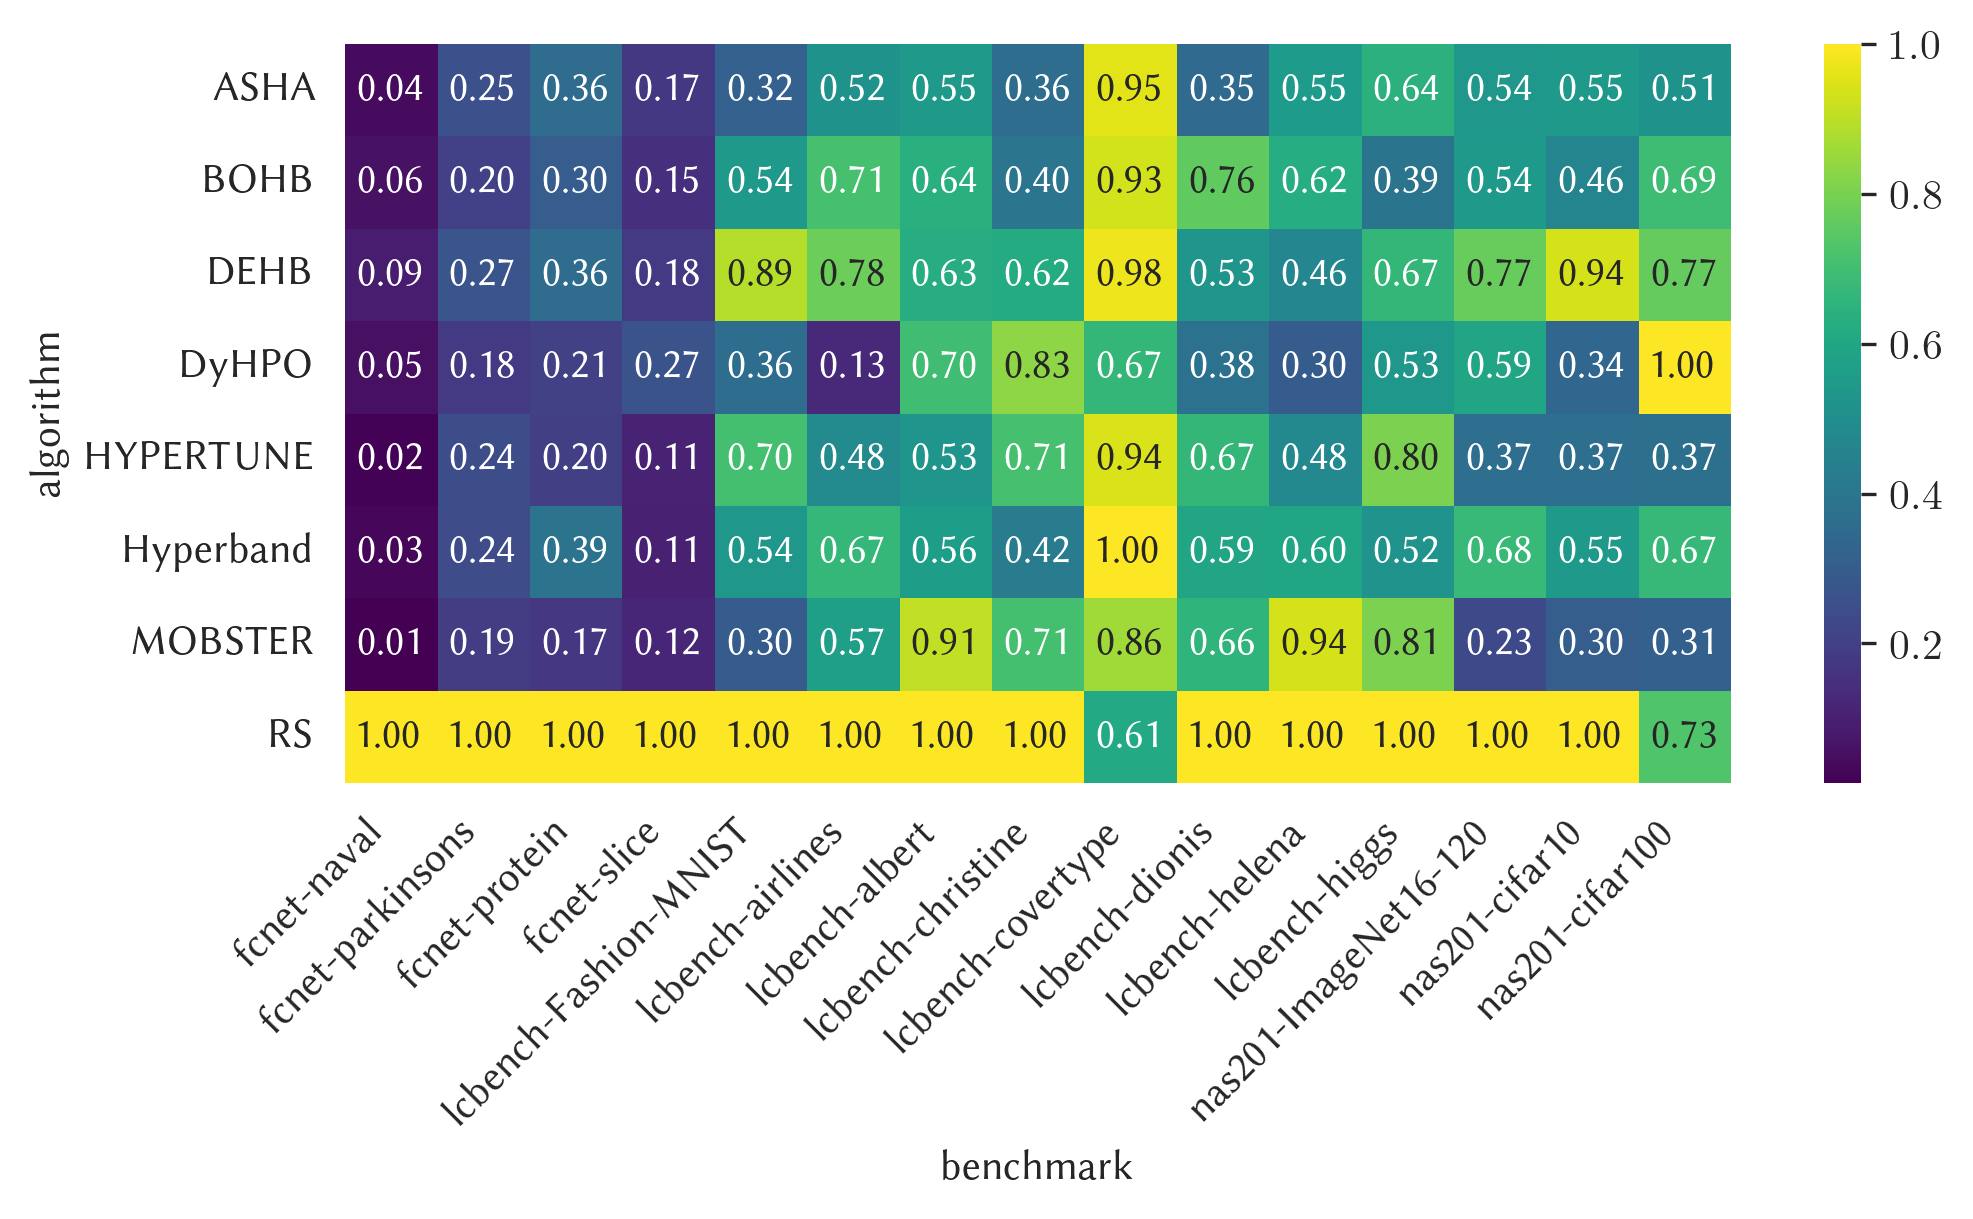

In [37]:
save = False
# Normalize stds for each column (benchmark)
stds = stds.div(stds.max(axis=0), axis=1)

print(stds.mean(axis=1))

# Plot the variances on a heatmap
plt.figure(figsize=(8, 3.2), dpi=300)
sns.heatmap(stds, annot=True, fmt=".2f", cmap='viridis', square=True)
plt.xticks(rotation=45, ha='right')
if save:
    plt.rcParams['savefig.format'] = 'pdf'
    plt.savefig('../../thesis/img/tabular_exp/stds_heatmap', bbox_inches='tight')

In [38]:
means.index

Index(['ASHA', 'BOHB', 'DEHB', 'DyHPO', 'HYPERTUNE', 'Hyperband', 'MOBSTER',
       'RS'],
      dtype='object', name='algorithm')

In [39]:
# Plot differences in the differences to see if they are normally distributed

#for algorithm1 in means.index:
#    for algorithm2 in means.index:
#        print(f'Comparing {algorithm1} and {algorithm2}')
#        a1 = means.loc[algorithm1]
#        a2 = means.loc[algorithm2]
#        diff = a1-a2
#        # Plot the KDE of the difference
#        sns.histplot(diff, kde=True)
#        plt.show()